In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import torch 
import numpy as np
from pyscf import gto, scf
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh,eigs
import scipy.linalg as la
import scipy.sparse as sp


warnings.filterwarnings('ignore')

In [2]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 


def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(hamiltonian_matrix)
print(len(hamiltonian_matrix))


tensor([[-0.7429+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j, -0.7970+0.0000j,  0.2495+0.0047j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.2495-0.0047j, -0.4701+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        ...,
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -0.4701+0.0000j, -0.2495-0.0047j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -0.2495+0.0047j, -0.7970+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j, -0.7429+0.0000j]],
       dtype=torch.complex128)
256


In [20]:
# Define the classical encoder neural network
class ClassicalEncoder(nn.Module):
    def __init__(self):
        super(ClassicalEncoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(16, 1),  # First layer with 7 inputs and 14 outputs
            nn.ReLU(),         # Activation function
            #nn.Linear(8,1), # Second layer with 14 inputs and 28 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(64, 32), # Third layer with 28 inputs and 56 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(32, 16), # Fourth layer reducing from 56 to 28 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(16, 8) # Fifth layer reducing from 28 to 14 outputs
        )
    
    def forward(self, x):
        return self.fc(x)

encoder = ClassicalEncoder()
#print("The encoder is: ", encoder)

def run_quantum_circuit(params):
    # Ensure input params is a list of values
    num_qubits= len(params)
    depth=1
    num_rotation_params = 3 * num_qubits * depth
    num_rxx_params = depth * (num_qubits - 1)  # One Rxx gate between each pair per layer
    total_params = num_rotation_params + num_rxx_params

    param_values = [params[i].item() for i in range(len(params))]
    
    # Create a list of parameters for the quantum circuit
    theta = [Parameter(f'θ{i}') for i in range(total_params)]
    param_counter = 0
    
    # Initialize the quantum circuit
    qc = QuantumCircuit(len(params), len(params))

    
    # Apply initial rotations
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            qc.rz(theta[qubit], qubit)
            param_counter += 1
            qc.rx(theta[qubit], qubit)
            param_counter += 1
            qc.rz(theta[qubit], qubit)
            param_counter += 1
        
        # Add the RXX gates for the even layers
        if layer % 2 == 0:
            for qubit in range(0, num_qubits - 1, 2):
                qc.rxx(theta[qubit], qubit, qubit + 1)
                param_counter += 1
        # Add the RXX gates for the odd layers
        else:
            for qubit in range(1, num_qubits - 1, 2):
                qc.rxx(theta[qubit], qubit, qubit + 1)
                param_counter += 1

    #print(param_counter)
    #print(len(theta))


    qc.barrier()

    # Add measurements
    qc.measure(range(len(params)), range(len(params)))
    #print(qc)
    
    # Bind the parameters to the values from the input
    qc_bound = qc.bind_parameters({theta[i]: param_values[i] for i in range(len(params))})
    
    # Execute the quantum circuit
    backend = Aer.get_backend('qasm_simulator')
    transpiled_circuit = transpile(qc_bound, backend)
    job = execute(transpiled_circuit, backend, shots=1024)
    result = job.result()
    counts = result.get_counts(transpiled_circuit)
    
    # Plotting is handled outside, just return counts or process further as needed
    
    # Convert the most common bitstring to numpy array and then to PyTorch tensor
    output_bitstring = max(counts, key=counts.get)
    output_data = np.array([int(bit) for bit in output_bitstring[::-1]])  # Reverse to match qubit ordering
    output_tensor = torch.tensor(output_data, dtype=torch.float32)
    
    return output_tensor



# Define the classical decoder neural network
class ClassicalDecoder(nn.Module):
    def __init__(self):
        super(ClassicalDecoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(8, 256),    # First layer with 4 inputs and 8 outputs
            #nn.ReLU(),          # Activation function
           # nn.Linear(8, 16),   # Second layer with 8 inputs and 16 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(16, 32),  # Third layer with 16 inputs and 32 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(32, 64),
            #nn.ReLU(),
            #nn.Linear(64, 128),  # Fourth layer reducing from 32 to 16 outputs
            #nn.ReLU(),          # Activation function
           # nn.Linear(128, 256)
        )
    
    def forward(self, x):
        return self.fc(x)

decoder = ClassicalDecoder()
#print("The decoder is: ", decoder)


class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        #self.encoder = ClassicalEncoder()
        self.decoder = ClassicalDecoder()
        self.qcircuit = run_quantum_circuit

    def forward(self, x):
        #encoded = self.encoder(x)
        quantum_result = self.qcircuit(x)
        decoded = self.decoder(quantum_result)
        return decoded

# Initialize the model
model = HybridModel()

In [21]:
def energy_expectation(output, hamiltonian):

    # Convert hamiltonian to double
    hamiltonian = hamiltonian.type(torch.double)

    # Convert output to double
    wavefunction = output.type(torch.double)

    # Normalize the wavefunction
    norm_wavefunction = wavefunction / torch.sqrt(torch.sum(torch.abs(wavefunction)**2))

    # Calculate the energy expectation value
    energy = torch.vdot(norm_wavefunction, torch.mv(hamiltonian, norm_wavefunction)).real

    return energy

In [22]:
# Sample input
input_data = torch.rand(8, requires_grad=True)  # Example input
#input_data= torch.tensor([ 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241, 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241])

# Optimization setup
#print("The model parameters are: ", model.parameters)
# Add weight decay to the optimizer (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 1000
loss_values = []

loss_function = nn.MSELoss()


for epoch in range(num_epochs):
    optimizer.zero_grad()            # Clear existing gradients
    output = model(input_data)       # Forward pass

    # Ensure output requires grad
    if not output.requires_grad:
        raise RuntimeError("Output does not require gradients. Check model implementation.")

    # Calculate the loss
    #initial_hamiltonian = hamiltonian_initial_module.mf.get_hcore()
    #final_hamiltonian = hamiltonian_final_module.mf.get_hcore()
    loss = energy_expectation(output,hamiltonian_matrix)
    # Check if loss requires grad
    if not loss.requires_grad:
        raise RuntimeError("Loss does not require gradients. Check energy_expectation implementation.")

    loss.backward()                  # Backward pass
    optimizer.step()                 # Update parameters
    loss_values.append(loss.item())  # Store loss for plotting
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/1000, Loss: -0.00022794724143541424
Epoch 2/1000, Loss: -0.8008641147327652
Epoch 3/1000, Loss: -1.239538698487521
Epoch 4/1000, Loss: -1.4600277596455082
Epoch 5/1000, Loss: -1.5843859748444586
Epoch 6/1000, Loss: -1.6757063163752375
Epoch 7/1000, Loss: -1.7528023781785194
Epoch 8/1000, Loss: -1.8188997932693234
Epoch 9/1000, Loss: -1.8748823123173242
Epoch 10/1000, Loss: -1.921986723876865
Epoch 11/1000, Loss: -1.9616670233837303
Epoch 12/1000, Loss: -1.9953630198437573
Epoch 13/1000, Loss: -2.024374601975677
Epoch 14/1000, Loss: -2.0497794349073994
Epoch 15/1000, Loss: -2.072405786328937
Epoch 16/1000, Loss: -2.092856276916423
Epoch 17/1000, Loss: -2.1115576601604484
Epoch 18/1000, Loss: -2.1288133177774693
Epoch 19/1000, Loss: -2.1448463405634115
Epoch 20/1000, Loss: -2.1598302995524348
Epoch 21/1000, Loss: -2.173908815537879
Epoch 22/1000, Loss: -2.1872064570266754
Epoch 23/1000, Loss: -2.1998337813680227
Epoch 24/1000, Loss: -2.21188934082722
Epoch 25/1000, Loss: -2.22346

In [6]:
import scipy.linalg as la

def find_lowest_eigenvalue(matrix):
    # Compute all eigenvalues, but only the first eigenvectors
    eigenvalues, _ = la.eigh(matrix, eigvals=(0, 0))
    return eigenvalues[0]

# Assuming large_matrix is your matrix
lowest_eigenvalue = find_lowest_eigenvalue(hamiltonian_matrix)
print("Lowest Eigenvalue:", lowest_eigenvalue)


Lowest Eigenvalue: -5.315575141437583


In [22]:
# for the no pqc ground state approximation was: -4.239352522251876
# for the pqc ground state: -4.253164531632698


### For N=4 SYK Model

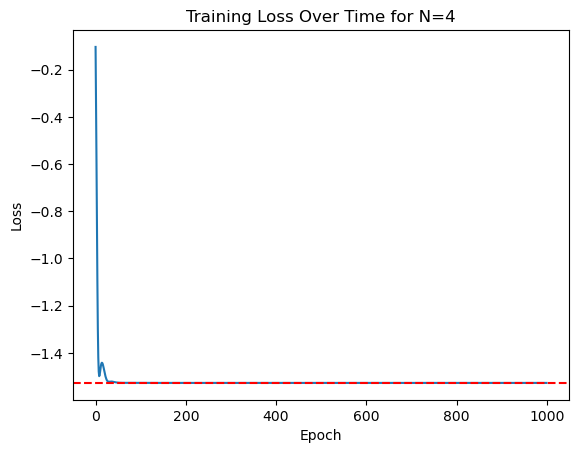

In [23]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=4')
plt.show()

### For N=8 SYK Model

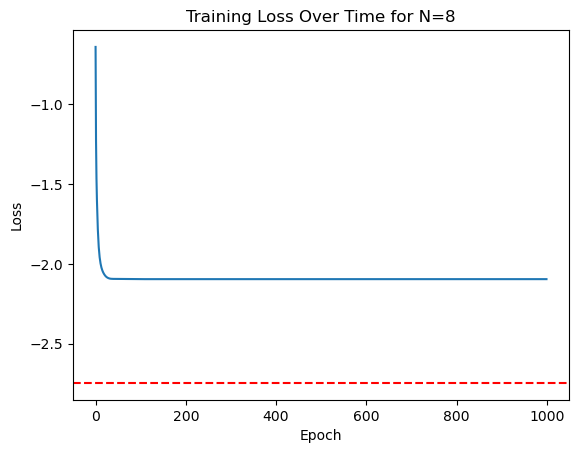

In [8]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=8')
plt.show()

## For Actual VQE for TFD

In [24]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 

import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import MatrixOp
import warnings
from qiskit.circuit.library import RZGate, RXGate, RXXGate
from math import pi

warnings.filterwarnings('ignore')

def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=7
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
#hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(len(hamiltonian_matrix))



# Convert the dense Hamiltonian matrix to a suitable operator for VQE
hamiltonian_operator = MatrixOp(hamiltonian_matrix)


# Define a simple parameterized circuit as the ansatz
def create_ansatz(num_qubits):
    depth=4
    # Define the number of parameters for the rotation gates
    num_params_per_rotation_layer = 3 * num_qubits
    # Define the number of parameters for the RXX gates
    num_params_per_rxx_layer = num_qubits // 2
    # Calculate the total number of parameters per layer
    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
    # Calculate the total number of parameters for all layers
    total_params = depth * num_params_per_layer

    # Initialize the parameter vector
    params = ParameterVector('θ', length=total_params)
    # Create the quantum circuit
    qc = QuantumCircuit(num_qubits)
    param_counter = 0  # Counter for the parameters

    # Construct the layers
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            qc.rz(params[param_counter], qubit)
            param_counter += 1
            qc.rx(params[param_counter], qubit)
            param_counter += 1
            qc.rz(params[param_counter], qubit)
            param_counter += 1
        
        # Add the RXX gates for the even layers
        if layer % 2 == 0:
            for qubit in range(0, num_qubits - 1, 2):
                qc.rxx(params[param_counter], qubit, qubit + 1)
                param_counter += 1
        # Add the RXX gates for the odd layers
        else:
            for qubit in range(1, num_qubits - 1, 2):
                qc.rxx(params[param_counter], qubit, qubit + 1)
                param_counter += 1

    return qc, params



num_qubits = int(np.log2(hamiltonian_matrix.shape[0]))
ansatz, parameters = create_ansatz(num_qubits)

# Use SPSA optimizer, it's suitable for noisy optimization like on a real quantum device
optimizer = ADAM(maxiter=1000)

# Setup quantum instance to use the statevector simulator
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# Initialize VQE with the ansatz, optimizer, and the quantum instance
vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)

# Run VQE to find the lowest eigenvalue of the Hamiltonian
vqe_result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_operator)

# Extract the lowest eigenvalue
lowest_eigenvalue = np.real(vqe_result.eigenvalue)
print("The VQE given lowest eigenvalue is: ", lowest_eigenvalue)

# Compare to exact solver
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(operator=hamiltonian_operator)

print('Exact Solver Result:', exact_result.eigenvalue.real)


128


KeyboardInterrupt: 

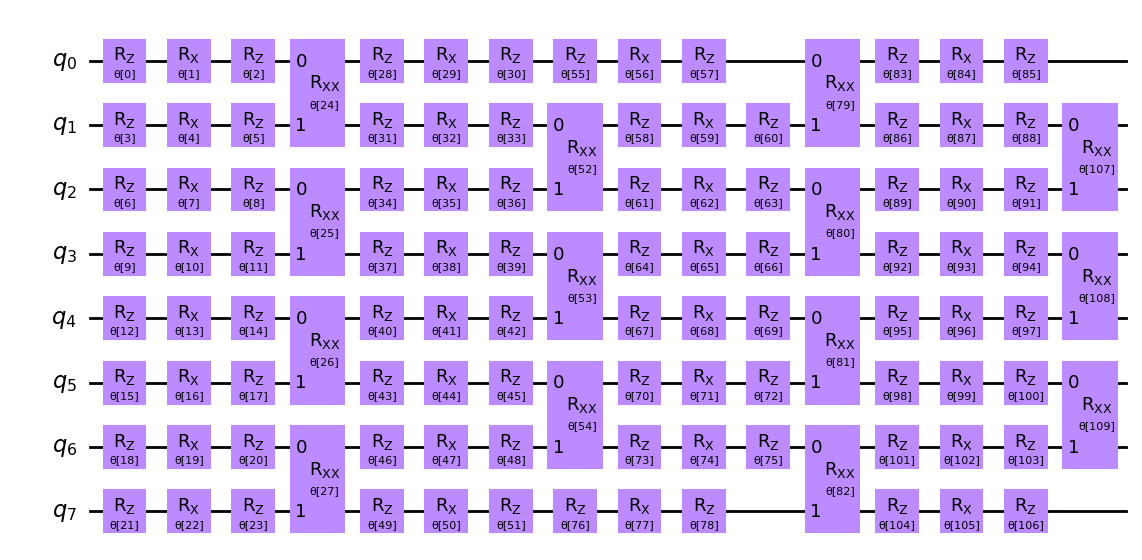

In [39]:
ansatz_circuit, _ = create_ansatz(num_qubits)
ansatz_circuit.draw('mpl')


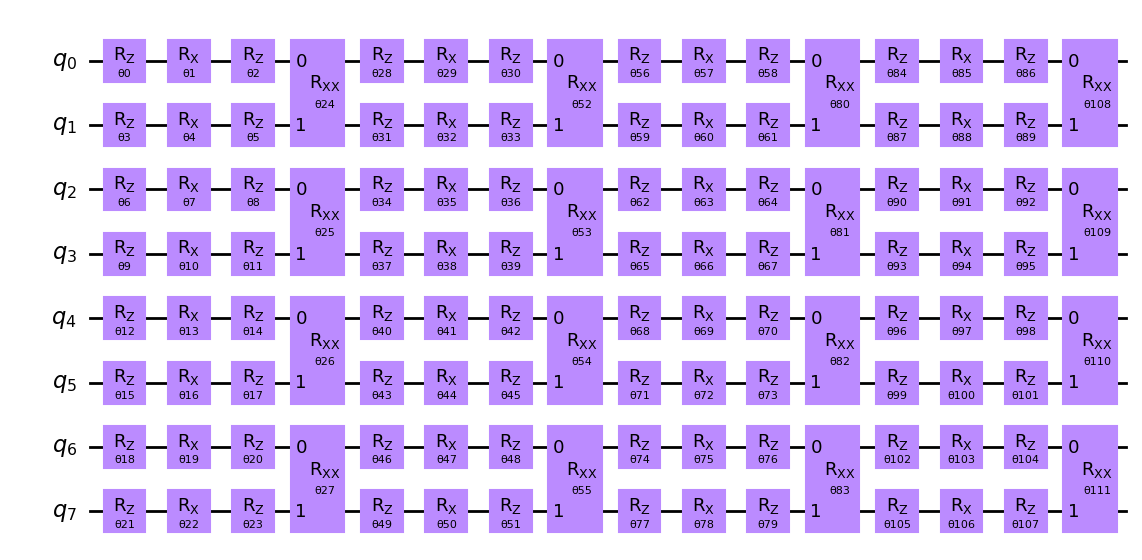

In [10]:
ansatz_circuit, _ = create_ansatz(num_qubits)
ansatz_circuit.draw('mpl')


In [3]:
"""

def create_ansatz(num_qubits):
    depth=4
    # Each layer has 3 rotations per qubit and half the number of qubits RXX gates
    num_params_per_rotation_layer = 3 * num_qubits
    num_params_per_rxx_layer = num_qubits // 2
    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
    total_params = depth * num_params_per_layer

    # Create a list of parameters
    params = [Parameter(f'θ{i}') for i in range(total_params)]
    qc = QuantumCircuit(num_qubits)

    # Assign parameters layer by layer
    for layer in range(depth):
        # Assign parameters for rotation gates
        for qubit in range(num_qubits):
            param_idx = layer * num_params_per_layer + qubit * 3
            qc.rz(params[param_idx], qubit)
            qc.rx(params[param_idx + 1], qubit)
            qc.rz(params[param_idx + 2], qubit)

        # Assign parameters for RXX gates in the layer
        for qubit in range(0, num_qubits, 2):
            param_idx = layer * num_params_per_layer + num_params_per_rotation_layer + qubit // 2
            qc.rxx(params[param_idx], qubit, qubit + 1)

    return qc, params
"""

"\n\ndef create_ansatz(num_qubits):\n    depth=4\n    # Each layer has 3 rotations per qubit and half the number of qubits RXX gates\n    num_params_per_rotation_layer = 3 * num_qubits\n    num_params_per_rxx_layer = num_qubits // 2\n    num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer\n    total_params = depth * num_params_per_layer\n\n    # Create a list of parameters\n    params = [Parameter(f'θ{i}') for i in range(total_params)]\n    qc = QuantumCircuit(num_qubits)\n\n    # Assign parameters layer by layer\n    for layer in range(depth):\n        # Assign parameters for rotation gates\n        for qubit in range(num_qubits):\n            param_idx = layer * num_params_per_layer + qubit * 3\n            qc.rz(params[param_idx], qubit)\n            qc.rx(params[param_idx + 1], qubit)\n            qc.rz(params[param_idx + 2], qubit)\n\n        # Assign parameters for RXX gates in the layer\n        for qubit in range(0, num_qubits, 2):\n            param

## Sample VQE

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
df= pd.read_csv('SYK_results.csv')
df

,Experiment_run,true_energy,hybrid_model_energy,difference,N
0,experiment_number_0,-5.315575,-2.777270,88.159720,8
1,experiment_number_1,-1.528238,-1.527674,0.039820,4
2,experiment_number_2,-2.745392,-2.095270,31.023244,6
3,experiment_number_3,-2.222125,-1.707276,29.687416,5
4,experiment_number_4,-5.315575,-2.825043,88.158857,8


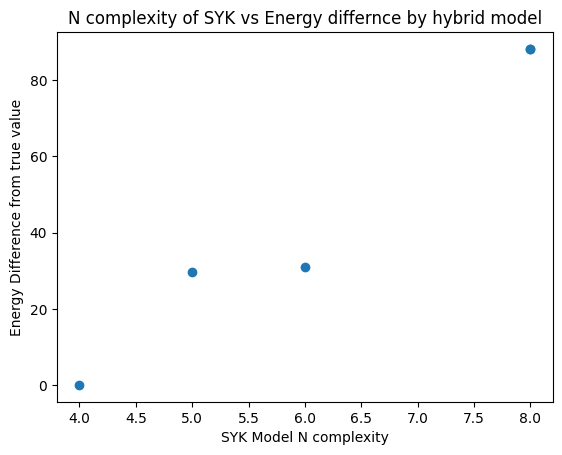

In [25]:
x= df['N']
y= df['difference']
plt.scatter(x,y)
plt.xlabel("SYK Model N complexity")
plt.ylabel("Energy Difference from true value")
plt.title("N complexity of SYK vs Energy differnce by hybrid model")
plt.show()

In [10]:
num_qubits = 8
depth = 4
num_params_per_rotation_layer = 3 * num_qubits
num_params_per_rxx_layer = num_qubits // 2
num_params_per_layer = num_params_per_rotation_layer + num_params_per_rxx_layer
total_params = depth * num_params_per_layer    

In [11]:
print(total_params)

112


In [93]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 

import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import MatrixOp
import warnings
from qiskit.circuit.library import RZGate, RXGate, RXXGate
from math import pi

warnings.filterwarnings('ignore')

def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
#hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(len(hamiltonian_matrix))



# Convert the dense Hamiltonian matrix to a suitable operator for VQE
hamiltonian_operator = MatrixOp(hamiltonian_matrix)


# Define a simple parameterized circuit as the ansatz
def create_ansatz(num_qubits):
    depth=4
    # Define the total number of parameters, accounting for rotations and Rxx gates
    num_rotation_params = 3 * num_qubits * depth
    num_rxx_params = depth * (num_qubits - 1)  # One Rxx gate between each pair per layer
    total_params = num_rotation_params + num_rxx_params

    # Initialize the parameter vector
    params = ParameterVector('θ', length=total_params)
    qc = QuantumCircuit(num_qubits)
    param_counter = 0  # Counter for the parameters

    # Construct the layers
    for layer in range(depth):
        # Add rotation layers
        for qubit in range(num_qubits):
            qc.rz(params[param_counter], qubit)
            param_counter += 1
            qc.rx(params[param_counter], qubit)
            param_counter += 1
            qc.rz(params[param_counter], qubit)
            param_counter += 1
        
        # Add the Rxx gates for the layer, creating a 'staircase' pattern
        for qubit in range(0, num_qubits - 1):
            # Skip the connection to create the staircase pattern
            if layer % 2 == 0 and qubit % 2 == 0:
                continue
            if layer % 2 == 1 and qubit % 2 == 1:
                continue
            # Apply the Rxx gate
            qc.rxx(params[param_counter], qubit, qubit + 1)
            param_counter += 1


    return qc, params



num_qubits = int(np.log2(hamiltonian_matrix.shape[0]))
ansatz, parameters = create_ansatz(num_qubits)

# Use SPSA optimizer, it's suitable for noisy optimization like on a real quantum device
optimizer = ADAM(maxiter=1000)

# Setup quantum instance to use the statevector simulator
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# Initialize VQE with the ansatz, optimizer, and the quantum instance
vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)

# Run VQE to find the lowest eigenvalue of the Hamiltonian
vqe_result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_operator)

# Extract the lowest eigenvalue
lowest_eigenvalue = np.real(vqe_result.eigenvalue)
print("The VQE given lowest eigenvalue is: ", lowest_eigenvalue)

# Compare to exact solver
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(operator=hamiltonian_operator)

print('Exact Solver Result:', exact_result.eigenvalue.real)


256
The VQE given lowest eigenvalue is:  -5.043611022848577
Exact Solver Result: -5.31557514143759


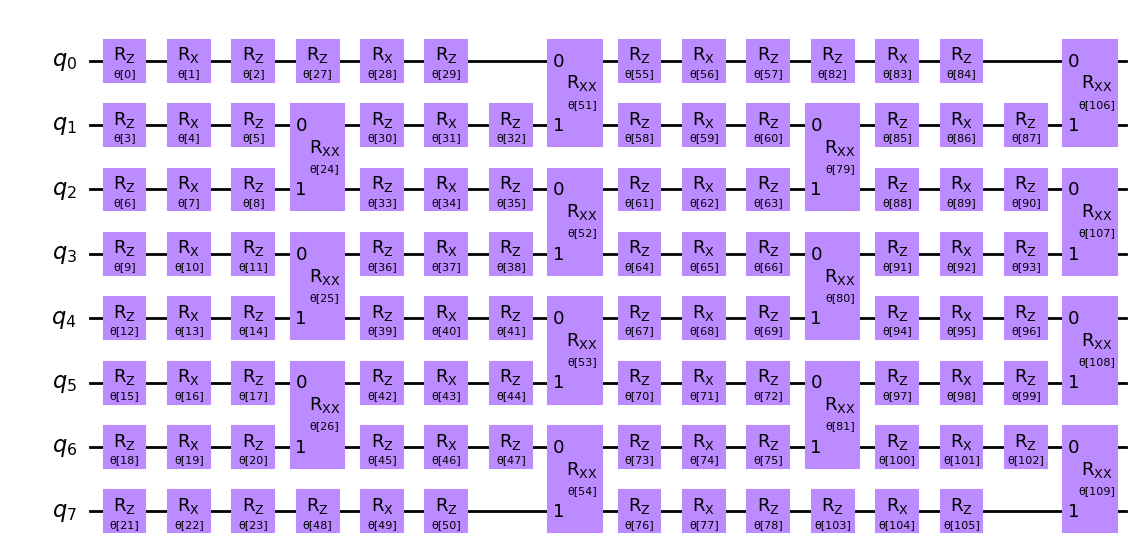

In [95]:
ansatz_circuit, _ = create_ansatz(num_qubits)
ansatz_circuit.draw('mpl')


In [84]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library.standard_gates import RXXGate

def create_tfd_ansatz(num_qubits, depth):
    # Create a parameter for each rotation gate and RXX gate
    total_params = 3 * num_qubits * depth  # Rotation gates
    # Assuming the depth is 1 for the pattern to match the given circuit
    rxx_params = num_qubits - 1  # RXX gates per layer
    total_params += rxx_params * depth
    
    # Initialize the quantum circuit for n qubits
    circuit = QuantumCircuit(num_qubits)
    params = [Parameter(f'θ{i}') for i in range(total_params)]
    param_counter = 0
    
    for d in range(depth):
        # Apply Rz, Rx, Rz rotations to each qubit
        for q in range(num_qubits):
            circuit.rz(params[param_counter], q)
            param_counter += 1
            circuit.rx(params[param_counter], q)
            param_counter += 1
            circuit.rz(params[param_counter], q)
            param_counter += 1
        
        # Apply RXX gates in the interleaved "zipper" pattern
        for q in range(0, num_qubits - 1):
            if (d % 2 == 0 and q % 2 == 0) or (d % 2 == 1 and q % 2 == 1):
                circuit.append(RXXGate(params[param_counter]), [q, q + 1])
                param_counter += 1
                circuit.barrier()

    return circuit, params

# Example usage for 8 qubits and 1 layer deep
num_qubits = 8
depth = 1
circuit, parameters = create_tfd_ansatz(num_qubits, depth)

# Output the circuit diagram
print(circuit.draw(output='text'))


      ┌────────┐ ┌────────┐ ┌────────┐┌───────────┐ ░               ░ »
q_0: ─┤ Rz(θ0) ├─┤ Rx(θ1) ├─┤ Rz(θ2) ├┤0          ├─░───────────────░─»
      ├────────┤ ├────────┤ ├────────┤│  Rxx(θ24) │ ░               ░ »
q_1: ─┤ Rz(θ3) ├─┤ Rx(θ4) ├─┤ Rz(θ5) ├┤1          ├─░───────────────░─»
      ├────────┤ ├────────┤ ├────────┤└───────────┘ ░ ┌───────────┐ ░ »
q_2: ─┤ Rz(θ6) ├─┤ Rx(θ7) ├─┤ Rz(θ8) ├──────────────░─┤0          ├─░─»
      ├────────┤┌┴────────┤┌┴────────┤              ░ │  Rxx(θ25) │ ░ »
q_3: ─┤ Rz(θ9) ├┤ Rx(θ10) ├┤ Rz(θ11) ├──────────────░─┤1          ├─░─»
     ┌┴────────┤├─────────┤├─────────┤              ░ └───────────┘ ░ »
q_4: ┤ Rz(θ12) ├┤ Rx(θ13) ├┤ Rz(θ14) ├──────────────░───────────────░─»
     ├─────────┤├─────────┤├─────────┤              ░               ░ »
q_5: ┤ Rz(θ15) ├┤ Rx(θ16) ├┤ Rz(θ17) ├──────────────░───────────────░─»
     ├─────────┤├─────────┤├─────────┤              ░               ░ »
q_6: ┤ Rz(θ18) ├┤ Rx(θ19) ├┤ Rz(θ20) ├──────────────░───────────